In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [2]:
# loading data
# uci_raw_data = pd.read_csv('Data/UCI_HAR_train.csv')
train_features = np.load('../Data/UCI_train_features.npy')
test_features = np.load('../Data/UCI_test_features.npy')
train_labels = np.load('../Data/UCI_train_labels.npy')
test_labels = np.load('../Data/UCI_test_labels.npy')
train_labels = train_labels - 1
test_labels = test_labels - 1

In [3]:
train_labels[:100]


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [4]:
# only features and label.
# uci_unprocessed = uci_raw_data[['x_acc','y_acc','z_acc','x_gyro','y_gyro','z_gyro','x_total_acc', 'y_total_acc', 'z_total_acc', 'activity']]

In [5]:
# uci_unprocessed.head(5)

In [6]:
# window_size: size of time window
# step: overlapping
# data: dataset
def time_windows(window_size,overlapping,data):
    sigmentation_data_temp = []
    sigmentation_data = []
    sigmentation_label = []

    for i in range(0,len(data),overlapping):
        acc_x = data['x_acc'].values[i:i+window_size]
        acc_y = data['y_acc'].values[i:i+window_size]
        acc_z = data['z_acc'].values[i:i+window_size]
        gyro_x = data['x_gyro'].values[i:i+window_size]
        gyro_y = data['y_gyro'].values[i:i+window_size]
        gyro_z = data['z_gyro'].values[i:i+window_size]
        total_acc_x = data['x_total_acc'].values[i:i+window_size]
        total_acc_y = data['y_total_acc'].values[i:i+window_size]
        total_acc_z = data['z_total_acc'].values[i:i+window_size]
        total_label = data['activity'].values[i:i+window_size]
        label = Counter(total_label).most_common()[0][0]
        sigmentation_data_temp.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z, total_acc_x, total_acc_y, total_acc_z])
        sigmentation_arr = np.asarray(sigmentation_data_temp)
        sig_size = sigmentation_arr.shape
        if sig_size[2] == window_size:
            sigmentation_arr.reshape(window_size,9)
            sigmentation_data.append(sigmentation_arr)
            sigmentation_label.append(label)
            sigmentation_data_temp = []
        else:
            sigmentation_data_temp = []

    sigmentation_data_arr = np.asarray(sigmentation_data)
    sigmentation_label_arr = np.asarray(sigmentation_label)

    return sigmentation_data_arr,sigmentation_label_arr


In [7]:
tensor_train_features = torch.Tensor(train_features)
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features)
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=32,shuffle=True)

In [9]:
# y = np.array(y_train)
# y_tf = tf.keras.utils.to_categorical(y-1, num_classes = 6)

In [10]:
# Hyper parameter 
BATCH_SIZE = 32# 32 # 
EPOCHES = 30

In [11]:
# size if of bacth, tensor 
images,labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 1, 9, 128]), torch.Size([32]))

In [12]:
# This is a batch of image u put in training or test

def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Recovery the image
    inp = np.clip(inp, 0, 1) # clip the pixel between 0 and 1
    plt.imshow(inp)
    #if titlle is not None:
        #plt.title(title)
   

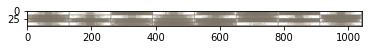

In [13]:
out = torchvision.utils.make_grid(images)
imshow(out)

### LSTM Model

In [14]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [15]:
input_dim = 128 # input dimension
hidden_dim = 300 # hidden layers number
layer_dim = 1
output_dim = 6  # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [16]:
for i in range(len(list(model_lstm.parameters()))):
    print("parameters: %d" %(i+1))
    print(list(model_lstm.parameters())[i].size())

parameters: 1
torch.Size([1200, 128])
parameters: 2
torch.Size([1200, 300])
parameters: 3
torch.Size([1200])
parameters: 4
torch.Size([1200])
parameters: 5
torch.Size([6, 300])
parameters: 6
torch.Size([6])


In [17]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

In [18]:
sequence_dim = 9
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

sequence_dim = 9
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0
def SGD(images, labels, train_loader, sequence_dim, input_dim):
    iter=0
    for epoch in range(EPOCHES):
        for i, (images, labels) in enumerate(train_loader):
            model_lstm.train()
            # 32*1*6*128
            images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
            labels = labels.to(torch.int64)
            #labels = labels.to(device)
            # gradient.zero
            optimizer.zero_grad()
            #forward pass

            outputs = model_lstm(images)
            # print(output.size(), labels.size(), "pass")
            # loss calc
            loss_lstm = criterion(outputs, labels)
            # backword
            loss_lstm.backward()
            # renew the parameter
            optimizer.step()

            iter += 1
            if iter % 500 == 0:
                model_lstm.eval()
                # accuracy
                correct = 0
                total = 0
                for i, (images, labels) in enumerate(train_loader):
                        images = images.view(-1, sequence_dim, input_dim)#.to(device)
                        outputs = model_lstm(images)
                        #print(outputs.size())

                        predict = torch.max(outputs.data, 1)[1]
                        total += labels.size(0)
                        correct += (predict == labels).sum()

                accuracy = correct / total * 100
                lost_list_LSTM.append(loss_lstm.data)
                accuracy_list.append(accuracy)
                iteration_list.append(iter)
                # print the info
                print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))

    return loss_lstm

In [19]:
SGD(images, labels, train_loader, sequence_dim, input_dim)

Iter:500,loss:0.9049347639083862,Accuracy:71.01469421386719
Iter:1000,loss:0.8298602104187012,Accuracy:70.44341278076172
Iter:1500,loss:0.8804218173027039,Accuracy:76.41458129882812
Iter:2000,loss:0.556556761264801,Accuracy:79.27095031738281
Iter:2500,loss:0.5032986998558044,Accuracy:82.0321044921875
Iter:3000,loss:0.534811794757843,Accuracy:78.18280792236328
Iter:3500,loss:0.7163978219032288,Accuracy:83.13384246826172
Iter:4000,loss:0.5194225311279297,Accuracy:82.6985855102539
Iter:4500,loss:0.4422662854194641,Accuracy:84.65723419189453
Iter:5000,loss:0.4314887821674347,Accuracy:84.2763900756836
Iter:5500,loss:0.38274288177490234,Accuracy:80.04624938964844
Iter:6000,loss:0.46212470531463623,Accuracy:83.2154541015625
Iter:6500,loss:0.5271632671356201,Accuracy:84.48040771484375


tensor(0.4608, grad_fn=<NllLossBackward0>)

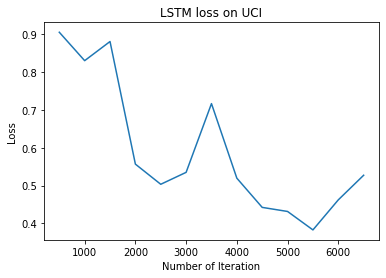

In [20]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM loss on UCI")
plt.show()

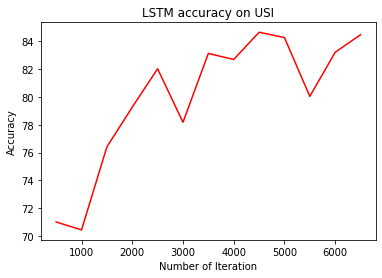

In [21]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM accuracy on USI")
plt.show()

In [22]:
labels = []
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
    
    print('Test Accuracy of the basic LSTM model on the UCI test features: {} %'.format((correct / total) * 100))

Test Accuracy of the basic LSTM model on the UCI test features: 80.42076873779297 %


Test Accuracy of the basic LSTM model on the UCI test features: 80.42076873779297 %


Text(36.41375, 0.5, 'predicted label')

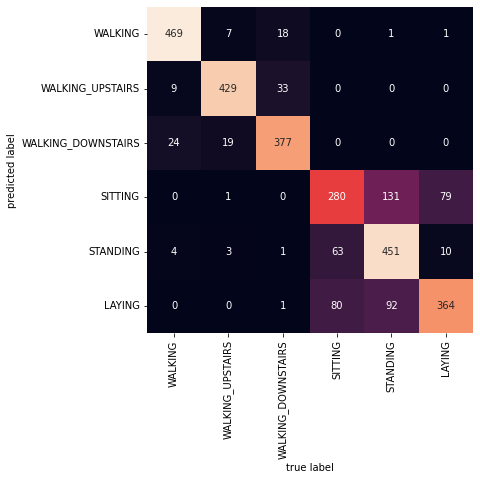

In [23]:
labels_list = []
predictions = []
classes = [
'WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic LSTM model on the UCI test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(6, 6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

### RNN try

In [24]:
# rnn
# num_feature = 6
# feature_width = 128
class RNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #iter
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = "relu")
        
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # DECAY THE GRADEINT to prevent gradient exposion
        out, hn = self.rnn(x, h0.detach())# detach 分离
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t
            
        return out
        

In [25]:
input_dim = 128 # input dimension
hidden_dim = 150 # hidden layers number
layer_dim = 2 
output_dim = 6 # output dimension

# initialize the model
model_rnn = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model_rnn.parameters(), lr = learning_rate)
length = (len(list(model_rnn.parameters())))
for i in range(length):
    print("parameters: %d" %(i+1))
    print(list(model_rnn.parameters())[i].size())

parameters: 1
torch.Size([150, 128])
parameters: 2
torch.Size([150, 150])
parameters: 3
torch.Size([150])
parameters: 4
torch.Size([150])
parameters: 5
torch.Size([150, 150])
parameters: 6
torch.Size([150, 150])
parameters: 7
torch.Size([150])
parameters: 8
torch.Size([150])
parameters: 9
torch.Size([6, 150])
parameters: 10
torch.Size([6])


In [27]:
sequence_dim = 9
loss_list = []
accuracy_list = []
iteration_list = [] 
# 24576 = 32*1*6*128
iter =  0
for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_rnn.train()
        # A batch of data with transfering the RNN input dimention 
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        output = model_rnn(images)

        
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_rnn = criterion(output, labels)
        # backword
        loss_rnn.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 500 == 0:
            model_rnn.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_rnn(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            loss_list.append(loss_rnn.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_rnn.item(), accuracy))

Iter:500,loss:0.46665632724761963,Accuracy:86.42546844482422
Iter:1000,loss:0.553337037563324,Accuracy:87.35037994384766
Iter:1500,loss:0.4959031343460083,Accuracy:87.63601684570312
Iter:2000,loss:0.20206870138645172,Accuracy:89.29542541503906
Iter:2500,loss:0.24092794954776764,Accuracy:88.15288543701172
Iter:3000,loss:0.2237594723701477,Accuracy:90.58760070800781
Iter:3500,loss:0.20859338343143463,Accuracy:89.51305389404297
Iter:4000,loss:0.1143048033118248,Accuracy:90.42437744140625
Iter:4500,loss:0.4028472900390625,Accuracy:90.58760070800781
Iter:5000,loss:0.13539189100265503,Accuracy:90.56039428710938
Iter:5500,loss:0.1717122346162796,Accuracy:90.3699722290039
Iter:6000,loss:0.1511600911617279,Accuracy:91.32209014892578
Iter:6500,loss:0.22214658558368683,Accuracy:91.34928894042969


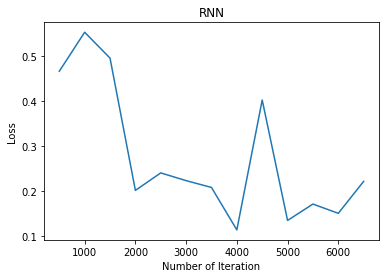

In [28]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("RNN")
plt.show()

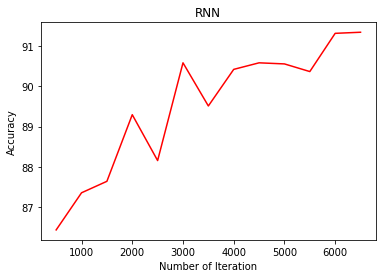

In [29]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("RNN")
plt.show()

Test Accuracy of the basic RNN model on the UCI test features: 82.04954528808594 %


Text(36.41375, 0.5, 'predicted label')

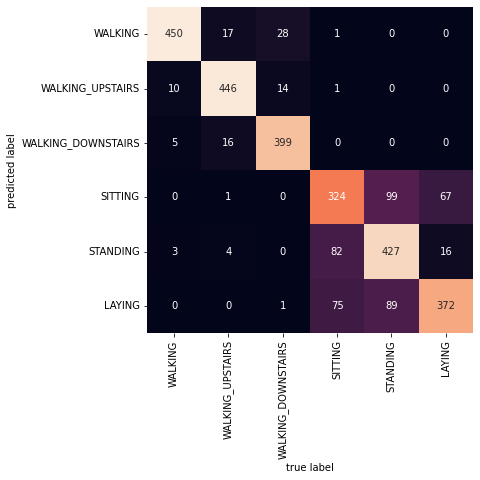

In [30]:
labels_list = []
predictions = []


with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_rnn(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic RNN model on the UCI test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(6, 6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')